# ESC-50のデータ前処理
https://qiita.com/cvusk/items/61cdbce80785eaf28349

## Librosa demo
http://nbviewer.jupyter.org/github/librosa/librosa/blob/master/examples/LibROSA%20demo.ipynb

In [1]:
!pip install librosa

## ESC-50
https://github.com/karoldvl/ESC-50

In [2]:
!git clone https://github.com/karoldvl/ESC-50.git

Cloning into 'ESC-50'...
remote: Counting objects: 4129, done.
remote: Total 4129 (delta 0), reused 0 (delta 0), pack-reused 4129
Receiving objects: 100% (4129/4129), 878.76 MiB | 33.05 MiB/s, done.
Resolving deltas: 100% (243/243), done.
Checking out files: 100% (2011/2011), done.


In [3]:
!ls

datalab  ESC-50  sample_data


## ラベルデータ読み込み

カンマ区切りのデータを扱うので、pandasを使用する。

In [0]:
import os
import random
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn import model_selection
from sklearn import preprocessing
import IPython.display as ipd

In [0]:
label_path = 'ESC-50/meta/esc50.csv'
audio_dir = 'ESC-50/audio/'
meta_data = pd.read_csv(label_path)

In [0]:
# get data size
data_size = meta_data.shape
print(data_size)

# arrange target label and its name
class_dict = {}
for i in range(data_size[0]):
    if meta_data.loc[i,"target"] not in class_dict.keys():
        class_dict[meta_data.loc[i,"target"]] = meta_data.loc[i,"category"]

(2000, 7)


In [0]:
class_dict

NameError: ignored

## 関数の定義

In [0]:
# load a wave data
def load_wave_data(audio_dir, file_name):
    file_path = os.path.join(audio_dir, file_name)
    x, fs = librosa.load(file_path, sr=44100)
    return x,fs

# change wave data to mel-stft
def calculate_melsp(x, n_fft=1024, hop_length=128):
    stft = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_length))**2
    log_stft = librosa.power_to_db(stft)
    melsp = librosa.feature.melspectrogram(S=log_stft,n_mels=128)
    return melsp

# display wave in plots
def show_wave(x):
    plt.plot(x)
    plt.show()

# display wave in heatmap
def show_melsp(melsp, fs):
    librosa.display.specshow(melsp, sr=fs)
    plt.colorbar()
    plt.show()



XXX行目のfilenameを取得
meta_data.loc[XXX , "filename"]

In [0]:
meta_data.loc[1,"filename"]

'1-100038-A-14.wav'

wave size:(220500,)
melsp size:(128, 1723)
samping rate:44100


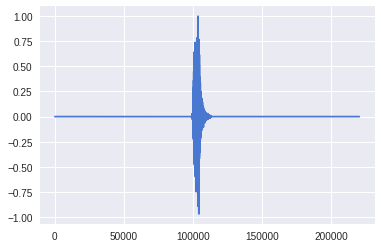

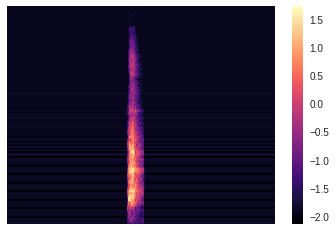

In [0]:
# example data
x, fs = load_wave_data(audio_dir, meta_data.loc[0,"filename"])
melsp = calculate_melsp(x)
print("wave size:{0}\nmelsp size:{1}\nsamping rate:{2}".format(x.shape, melsp.shape, fs))
show_wave(x)
show_melsp(melsp, fs)

## Augmentation

In [0]:
# data augmentation: add white noise
def add_white_noise(x, rate=0.002):
    return x + rate*np.random.randn(len(x))

# data augmentation: shift sound in timeframe
def shift_sound(x, rate=2):
    return np.roll(x, int(len(x)//rate))

# data augmentation: stretch sound
def stretch_sound(x, rate=1.1):
    input_length = len(x)
    x = librosa.effects.time_stretch(x, rate)
    if len(x)>input_length:
        return x[:input_length]
    else:
        return np.pad(x, (0, max(0, input_length - len(x))), "constant")

## メルスペクトログラムの取得

In [0]:
import librosa
import librosa.display

# change wave data to mel-stft
def calculate_melsp(x, n_fft=1024, hop_length=128):
    stft = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_length))**2
    log_stft = librosa.power_to_db(stft)
    melsp = librosa.feature.melspectrogram(S=log_stft,n_mels=128)
    return melsp

## データを分割

In [6]:
# get training dataset and target dataset
x = list(meta_data.loc[:,"filename"])
y = list(meta_data.loc[:, "target"])
print( "original x,y = %d,%d" %(len(x),len(y)) )

original x,y = 2000,2000


In [0]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.25, stratify=y)

In [48]:
len(y_train)

1500

In [0]:
print("x train:{0}\ny train:{1}\nx test:{2}\ny test:{3}".format(len(x_train),
                                                                len(y_train), 
                                                                len(x_test), 
                                                                len(y_test)))

x train:1500
y train:1500
x test:500
y test:500


## 訓練データ、テストデータの作成

In [0]:
freq = 128
time = 1723

# save wave data in npz, with augmentation
def save_np_data(filename, x, y, aug=None, rates=None):
    np_data = np.zeros(freq*time*len(x)).reshape(len(x), freq, time)
    np_targets = np.zeros(len(y))
    for i in range(len(y)):
        _x, fs = load_wave_data(audio_dir, x[i])
        if aug is not None:
            _x = aug(x=_x, rate=rates[i])
        _x = calculate_melsp(_x)
        np_data[i] = _x
        np_targets[i] = y[i]
    np.savez(filename, x=np_data, y=np_targets)  

# save test dataset
if not os.path.exists("esc_melsp_test.npz"):
    save_np_data("esc_melsp_test.npz", x_test,  y_test)

# save raw training dataset
if not os.path.exists("esc_melsp_train_raw.npz"):
    save_np_data("esc_melsp_train_raw.npz", x_train,  y_train)

# save training dataset with white noise
if not os.path.exists("esc_melsp_train_wn.npz"):
    rates = np.random.randint(1,50,len(x_train))/10000
    save_np_data("esc_melsp_train_wn.npz", x_train,  y_train, aug=add_white_noise, rates=rates)

# save training dataset with sound shift
if not os.path.exists("esc_melsp_train_ss.npz"):
    rates = np.random.choice(np.arange(2,6),len(y_train))
    save_np_data("esc_melsp_train_ss.npz", x_train,  y_train, aug=shift_sound, rates=rates)

# save training dataset with stretch
if not os.path.exists("esc_melsp_train_st.npz"):
    rates = np.random.choice(np.arange(80,120),len(y_train))/100
    save_np_data("esc_melsp_train_st.npz", x_train,  y_train, aug=stretch_sound, rates=rates)

# save training dataset with combination of white noise and shift or stretch
if not os.path.exists("esc_melsp_train_com.npz"):
    np_data = np.zeros(freq*time*len(x_train)).reshape(len(x_train), freq, time)
    np_targets = np.zeros(len(y_train))
    for i in range(len(y_train)):
        x, fs = load_wave_data(audio_dir, x_train[i])
        x = add_white_noise(x=x, rate=np.random.randint(1,50)/1000)
        if np.random.choice((True,False)):
            x = shift_sound(x=x, rate=np.random.choice(np.arange(2,6)))
        else:
            x = stretch_sound(x=x, rate=np.random.choice(np.arange(80,120))/100)
        x = calculate_melsp(x)
        np_data[i] = x
        np_targets[i] = y_train[i]
    np.savez("esc_melsp_train_com.npz", x=np_data, y=np_targets)

In [0]:
!ls

datalab		    esc_melsp_train_com.npz  esc_melsp_train_st.npz
ESC-50		    esc_melsp_train_raw.npz  esc_melsp_train_wn.npz
esc_melsp_test.npz  esc_melsp_train_ss.npz


## ColaboratoryからGoogle Driveへのファイル保存
https://qiita.com/kakinaguru_zo/items/33dbe24276915124f545

In [0]:
import google.colab
import googleapiclient.discovery
import googleapiclient.http

In [0]:
google.colab.auth.authenticate_user()
drive_service = googleapiclient.discovery.build('drive', 'v3')

ファイルは全6種なので、手作業でファイル名を変更した。   

  esc_melsp_train_com.npz   
  esc_melsp_train_st.npz   
  esc_melsp_train_raw.npz   
  esc_melsp_train_wn.npz   
  esc_melsp_test.npz   
  esc_melsp_train_ss.npz   

In [0]:
saving_filename = "esc_melsp_train_raw.npz"

In [9]:
file_metadata = {
  'name': saving_filename,
  'mimeType': 'application/octet-stream'
}
media = googleapiclient.http.MediaFileUpload(saving_filename, 
                        mimetype='application/octet-stream',
                        resumable=True)
created = drive_service.files().create(body=file_metadata,
                                       media_body=media,
                                       fields='id').execute()

FileNotFoundError: ignored

# DriveからColaboratoryへのファイル取り込み
https://qiita.com/kakinaguru_zo/items/33dbe24276915124f545

In [7]:
!ls

adc.json  datalab  ESC-50  esc_melsp_train_raw.npz  sample_data


In [0]:
import google.colab
import googleapiclient.discovery
import googleapiclient.http

In [0]:
google.colab.auth.authenticate_user()
drive_service = googleapiclient.discovery.build('drive', 'v3')

In [3]:
""""""
upload_filename_list = ["esc_melsp_train_com.npz",
                        "esc_melsp_train_st.npz",
                        "esc_melsp_train_raw.npz",
                        "esc_melsp_train_wn.npz",
                        "esc_melsp_test.npz",
                        "esc_melsp_train_ss.npz"]
""""""
upload_filename_list = ["esc_melsp_train_raw.npz", "esc_melsp_test.npz"]

for iii in upload_filename_list:

    upload_filename = iii
    #upload_filename = 'esc_melsp_train_st.npz'
    
    file_list = drive_service.files().list(q="name='" + upload_filename + "'").execute().get('files')
    
    # ファイル ID を取得します。
    file_id = None
    for file in file_list:
      if file.get('name') == upload_filename:
        file_id = file.get('id')
        break
    
    if file_id is None:
      # ファイル ID を取得できなかった場合はエラーメッセージを出力します。
      print(upload_filename + ' が見つかりません.')
    else:
      # colab 環境へファイルをアップロードします。
      with open(upload_filename, 'wb') as f:
        request = drive_service.files().get_media(fileId=file_id)
        media = googleapiclient.http.MediaIoBaseDownload(f, request)
    
        done = False
        while not done:
          progress_status, done = media.next_chunk()
          print(100*progress_status.progress(), end="")
          print("%完了")
    
      print('GoogleドライブからColab環境へのファイル取り込みが完了しました.')

3.962062848068676%完了
7.924125696137352%完了
11.886188544206028%完了
15.848251392274705%完了
19.81031424034338%完了
23.772377088412057%完了
27.734439936480733%完了
31.69650278454941%完了
35.658565632618085%完了
39.62062848068676%完了
43.58269132875544%完了
47.544754176824114%完了
51.50681702489279%完了
55.468879872961466%完了
59.43094272103014%完了
63.39300556909882%完了
67.3550684171675%完了
71.31713126523617%完了
75.27919411330485%完了
79.24125696137352%完了
83.2033198094422%完了
87.16538265751088%完了
91.12744550557956%完了
95.08950835364823%完了
99.05157120171691%完了
100.0%完了
GoogleドライブからColab環境へのファイル取り込みが完了しました.
11.886185076987367%完了
23.772370153974734%完了
35.6585552309621%完了
47.54474030794947%完了
59.43092538493684%完了
71.3171104619242%完了
83.20329553891158%完了
95.08948061589894%完了
100.0%完了
GoogleドライブからColab環境へのファイル取り込みが完了しました.


In [11]:
!ls

adc.json  datalab  ESC-50  esc_melsp_train_raw.npz  sample_data


## python に .npzを読み込ませる

In [0]:
import numpy as np

In [0]:
x_train=np.load("esc_melsp_train_raw.npz")['x']

In [28]:
x_train

array([[[ 2.66609496e-01,  2.06880123e-01, -5.79679420e-03, ...,
         -7.78497392e-01, -3.24217847e-01, -1.28719773e-01],
        [ 5.11864678e-01,  4.50734234e-01,  2.33865823e-01, ...,
         -2.69144884e-01, -1.49023748e-01, -3.06212419e-02],
        [ 7.70400659e-01,  7.22690716e-01,  5.76525109e-01, ...,
          1.45620007e-01,  1.75963843e-01,  1.21148065e-01],
        ...,
        [-1.97433983e+00, -1.97433983e+00, -1.97433983e+00, ...,
         -1.97433983e+00, -1.97433983e+00, -1.97433983e+00],
        [-1.97356058e+00, -1.97356058e+00, -1.97356058e+00, ...,
         -1.97356058e+00, -1.97356058e+00, -1.97356058e+00],
        [-1.97254181e+00, -1.97254181e+00, -1.97254181e+00, ...,
         -1.97254181e+00, -1.97254181e+00, -1.97254181e+00]],

       [[-9.27727147e-01, -6.16434339e-01, -4.25746929e-01, ...,
         -1.91473758e+00, -1.91473758e+00, -1.91473758e+00],
        [-1.47430807e+00, -8.29524260e-01, -3.85477157e-01, ...,
         -1.91473758e+00, -1.91473758e

⊛必ずreshapeする事    
mnistのcnnを参考にした


In [0]:
x_train = x_train.reshape(1500, 128, 1723, 1)

In [31]:
x_train

array([[[[ 2.66609496e-01],
         [ 2.06880123e-01],
         [-5.79679420e-03],
         ...,
         [-7.78497392e-01],
         [-3.24217847e-01],
         [-1.28719773e-01]],

        [[ 5.11864678e-01],
         [ 4.50734234e-01],
         [ 2.33865823e-01],
         ...,
         [-2.69144884e-01],
         [-1.49023748e-01],
         [-3.06212419e-02]],

        [[ 7.70400659e-01],
         [ 7.22690716e-01],
         [ 5.76525109e-01],
         ...,
         [ 1.45620007e-01],
         [ 1.75963843e-01],
         [ 1.21148065e-01]],

        ...,

        [[-1.97433983e+00],
         [-1.97433983e+00],
         [-1.97433983e+00],
         ...,
         [-1.97433983e+00],
         [-1.97433983e+00],
         [-1.97433983e+00]],

        [[-1.97356058e+00],
         [-1.97356058e+00],
         [-1.97356058e+00],
         ...,
         [-1.97356058e+00],
         [-1.97356058e+00],
         [-1.97356058e+00]],

        [[-1.97254181e+00],
         [-1.97254181e+00],
         [

In [0]:
y_train=np.load("esc_melsp_train_raw.npz")['y']

# 深層学習

In [16]:
#import tensorflow as tf
#device_name = tf.test.gpu_device_name()
#if device_name != '/device:GPU:0':
#  raise SystemError('GPU device not found')
#print('Found GPU at: {}'.format(device_name))

import keras
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Activation
from keras.layers import Conv2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization, Add
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [0]:
# redefine target data into one hot vector
classes = 50
y_train = keras.utils.to_categorical(y_train, classes)

In [18]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [0]:
def cba(inputs, filters, kernel_size, strides):
    x = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [20]:
x_train.shape[1:]

(128, 1723, 1)

https://stackoverflow.com/questions/47665391/keras-valueerror-input-0-is-incompatible-with-layer-conv2d-1-expected-ndim-4?rq=1

RGB画像ではないので、チャンネル数を１に設定した

In [0]:
inputs=Input(shape=(128, 1723, 1))

## モデル作成

In [25]:
x_1 = cba(inputs, filters=32, kernel_size=(1,8), strides=(1,2))
x_1 = cba(x_1, filters=32, kernel_size=(8,1), strides=(2,1))
x_1 = cba(x_1, filters=64, kernel_size=(1,8), strides=(1,2))
x_1 = cba(x_1, filters=64, kernel_size=(8,1), strides=(2,1))

x_2 = cba(inputs, filters=32, kernel_size=(1,16), strides=(1,2))
x_2 = cba(x_2, filters=32, kernel_size=(16,1), strides=(2,1))
x_2 = cba(x_2, filters=64, kernel_size=(1,16), strides=(1,2))
x_2 = cba(x_2, filters=64, kernel_size=(16,1), strides=(2,1))

x_3 = cba(inputs, filters=32, kernel_size=(1,32), strides=(1,2))
x_3 = cba(x_3, filters=32, kernel_size=(32,1), strides=(2,1))
x_3 = cba(x_3, filters=64, kernel_size=(1,32), strides=(1,2))
x_3 = cba(x_3, filters=64, kernel_size=(32,1), strides=(2,1))

x_4 = cba(inputs, filters=32, kernel_size=(1,64), strides=(1,2))
x_4 = cba(x_4, filters=32, kernel_size=(64,1), strides=(2,1))
x_4 = cba(x_4, filters=64, kernel_size=(1,64), strides=(1,2))
x_4 = cba(x_4, filters=64, kernel_size=(64,1), strides=(2,1))

x = Add()([x_1, x_2, x_3, x_4])

x = cba(x, filters=128, kernel_size=(1,16), strides=(1,2))
x = cba(x, filters=128, kernel_size=(16,1), strides=(2,1))

x = GlobalAveragePooling2D()(x)
x = Dense(classes)(x)
x = Activation("softmax")(x)

model = Model(inputs, x)

# initiate Adam optimizer
opt = keras.optimizers.adam(lr=0.00001, decay=1e-6, amsgrad=True)

# Let's train the model using Adam with amsgrad
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 1723, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 862, 32) 288         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 128, 862, 32) 544         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 128, 862, 32) 1056        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_13 

In [32]:
model.fit(x_train, y_train, epochs=3, batch_size=15)

Epoch 1/3
1500/1500 [==============================] - 302s 202ms/step - loss: 3.8699 - acc: 0.0473
Epoch 2/3
1500/1500 [==============================] - 289s 193ms/step - loss: 3.6811 - acc: 0.0873
Epoch 3/3
1500/1500 [==============================] - 288s 192ms/step - loss: 3.5516 - acc: 0.1107


## テストデータのロード

In [0]:
import google.colab
import googleapiclient.discovery
import googleapiclient.http

In [0]:
google.colab.auth.authenticate_user()
drive_service = googleapiclient.discovery.build('drive', 'v3')

In [53]:
upload_filename = "esc_melsp_test.npz"

file_list = drive_service.files().list(q="name='" + upload_filename + "'").execute().get('files')

# ファイル ID を取得します。
file_id = None
for file in file_list:
  if file.get('name') == upload_filename:
    file_id = file.get('id')
    break

if file_id is None:
  # ファイル ID を取得できなかった場合はエラーメッセージを出力します。
  print(upload_filename + ' が見つかりません.')
else:
  # colab 環境へファイルをアップロードします。
  with open(upload_filename, 'wb') as f:
    request = drive_service.files().get_media(fileId=file_id)
    media = googleapiclient.http.MediaIoBaseDownload(f, request)

    done = False
    while not done:
      progress_status, done = media.next_chunk()
      print(100*progress_status.progress(), end="")
      print("%完了")

  print('GoogleドライブからColab環境へのファイル取り込みが完了しました.')

11.886185076987367%完了
23.772370153974734%完了
35.6585552309621%完了
47.54474030794947%完了
59.43092538493684%完了
71.3171104619242%完了
83.20329553891158%完了
95.08948061589894%完了
100.0%完了
GoogleドライブからColab環境へのファイル取り込みが完了しました.


In [7]:
import numpy as np
import keras
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Activation
from keras.layers import Conv2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization, Add
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [0]:
classes=50
x_test=np.load("esc_melsp_test.npz")['x']
x_test = x_test.reshape(500, 128, 1723, 1)
y_test=np.load("esc_melsp_test.npz")['y']
y_test = keras.utils.to_categorical(y_test, classes)

In [62]:
x_test.shape

(1500, 128, 1723)

## モデルの評価

In [0]:
score = model.evaluate(x_test, y_test, verbose=0)
print(score)

In [17]:
score

[1.3588806066513062, 0.6780000009536743]

## ACC, Loss可視化
https://qiita.com/hiroyuki827/items/213146d551a6e2227810

In [0]:
import matplotlib as plt

In [31]:
# ----------------------------------------------
# Some plots
# ----------------------------------------------
#fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))

# loss
def plot_history_loss(fit):
    # Plot the loss in the history
    axL.plot(fit.history['loss'],label="loss for training")
    axL.plot(fit.history['val_loss'],label="loss for validation")
    axL.set_title('model loss')
    axL.set_xlabel('epoch')
    axL.set_ylabel('loss')
    axL.legend(loc='upper right')

# acc
def plot_history_acc(fit):
    # Plot the loss in the history
    axR.plot(fit.history['acc'],label="loss for training")
    axR.plot(fit.history['val_acc'],label="loss for validation")
    axR.set_title('model accuracy')
    axR.set_xlabel('epoch')
    axR.set_ylabel('accuracy')
    axR.legend(loc='upper right')

plot_history_loss(model)
plot_history_acc(model)
#fig.savefig('./mnist-tutorial.png')
#plt.close()

NameError: ignored

## KerasのConv2D関数のパラメーターfiltersとは？   
https://teratail.com/questions/94576

## 学習モデルの保存
http://uchidama.hatenablog.com/entry/2017/12/28/171838

In [0]:
model.save("model_SC50_cnn_web_raw_epo170_bat15.h5")

In [24]:
!ls

adc.json		 model_SC50_cnn_web_raw_epo100_bat15.h5
datalab			 model_SC50_cnn_web_raw_epo3_bat15.h5
ESC-50			 model_SC50_cnn_web_raw_epo3_bat50.h5
esc_melsp_test.npz	 model_SC50_cnn_web_raw_epo50_bat15.h5
esc_melsp_train_raw.npz  sample_data


In [0]:
saving_filename = "model_SC50_cnn_web_raw_epo170_bat15.h5"

In [0]:
file_metadata = {
  'name': saving_filename,
  'mimeType': 'application/octet-stream'
}
media = googleapiclient.http.MediaFileUpload(saving_filename, 
                        mimetype='application/octet-stream',
                        resumable=True)
created = drive_service.files().create(body=file_metadata,
                                       media_body=media,
                                       fields='id').execute()

In [22]:
!ls

adc.json		 model_SC50_cnn_web_raw_epo100_bat15.h5
datalab			 model_SC50_cnn_web_raw_epo3_bat15.h5
ESC-50			 model_SC50_cnn_web_raw_epo3_bat50.h5
esc_melsp_test.npz	 model_SC50_cnn_web_raw_epo50_bat15.h5
esc_melsp_train_raw.npz  sample_data


## driveからモデルを取り込む

In [0]:
import google.colab
import googleapiclient.discovery
import googleapiclient.http

In [0]:
google.colab.auth.authenticate_user()
drive_service = googleapiclient.discovery.build('drive', 'v3')

In [10]:
upload_filename = "model_SC50_cnn_web_raw_epo170_bat15.h5"

file_list = drive_service.files().list(q="name='" + upload_filename + "'").execute().get('files')

# ファイル ID を取得します。
file_id = None
for file in file_list:
  if file.get('name') == upload_filename:
    file_id = file.get('id')
    break

if file_id is None:
  # ファイル ID を取得できなかった場合はエラーメッセージを出力します。
  print(upload_filename + ' が見つかりません.')
else:
  # colab 環境へファイルをアップロードします。
  with open(upload_filename, 'wb') as f:
    request = drive_service.files().get_media(fileId=file_id)
    media = googleapiclient.http.MediaIoBaseDownload(f, request)

    done = False
    while not done:
      progress_status, done = media.next_chunk()
      print(100*progress_status.progress(), end="")
      print("%完了")

  print('GoogleドライブからColab環境へのファイル取り込みが完了しました.')

100.0%完了
GoogleドライブからColab環境へのファイル取り込みが完了しました.


In [0]:
from keras.models import load_model

In [15]:
model = load_model("model_SC50_cnn_web_raw_epo170_bat15.h5")

## 学習モデルを再度学習させる   
https://teratail.com/questions/84511

In [0]:
import numpy as np

In [0]:
x_train=np.load("esc_melsp_train_raw.npz")['x']

In [0]:
x_train = x_train.reshape(1500, 128, 1723, 1)

In [0]:
y_train=np.load("esc_melsp_train_raw.npz")['y']

In [0]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Activation
from keras.layers import Conv2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization, Add
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [0]:
# redefine target data into one hot vector
classes = 50
y_train = keras.utils.to_categorical(y_train, classes)
#y_test = keras.utils.to_categorical(y_test, classes)

In [15]:
model.fit(x_train, y_train, epochs=70, batch_size=15)

Epoch 1/70
1500/1500 [==============================] - 295s 197ms/step - loss: 1.7208 - acc: 0.6713
Epoch 2/70
1500/1500 [==============================] - 277s 184ms/step - loss: 1.7425 - acc: 0.6507
Epoch 3/70
1500/1500 [==============================] - 280s 187ms/step - loss: 1.7117 - acc: 0.6593
Epoch 4/70
1500/1500 [==============================] - 280s 186ms/step - loss: 1.6932 - acc: 0.6673
Epoch 5/70
1500/1500 [==============================] - 278s 186ms/step - loss: 1.6979 - acc: 0.6753
Epoch 6/70
1500/1500 [==============================] - 277s 184ms/step - loss: 1.6946 - acc: 0.6700
Epoch 7/70
1500/1500 [==============================] - 281s 187ms/step - loss: 1.6674 - acc: 0.6667
Epoch 8/70
1500/1500 [==============================] - 279s 186ms/step - loss: 1.6645 - acc: 0.6687
Epoch 9/70
1500/1500 [==============================] - 278s 185ms/step - loss: 1.6717 - acc: 0.6660
Epoch 10/70
1500/1500 [==============================] - 277s 184ms/step - loss: 1.6607 - a